In [2]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

import WatercareConstants as WC
import DataAnalysisConstants as DAC
import Files as FILES

import GetFailures as  gf
import PlotUtils as pu

OTHER = 'Other'
SR_PROB_TO_FILTER = "SR_PROB_TO_FILTER"

MAX_PERCEN_TOSHOW = 2

MATERIALS_PREDOMI = [WC.AC,WC.PVC,DAC.IRON,WC.PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

PressFluc_bins = [0,3,6,9,12,15,20,35]
PFlucRange_labels = ['(0,3]','(3,6]','(6,9]','(9,12]','(12,15]','(15,20]','(20,35]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

# -------------------- CONST --------------------

In [4]:
def getMaterialConst():
    
    fmaterialsConst= FILES.MAT_CONSTS

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[WC.MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DAC.DIAMETER])
    
    return diameterConst

In [5]:
fname = FILES.WORK_ORDERS

wPipesGISNfailures, mainFailures = gf.getFailures(fname)

consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [7]:
#It finds the materials with significant percentage of pipe length
#it labels all other materials as OTHER, calculates the % of pipe length of each materials
# and assings the color values of each material 
def groupByMaterial(df):
    
	groupMat = df.groupby([WC.MATERIAL]).agg({WC.LENG: 'sum'}).copy()

	#Creates the otherMaterials table to create the material "other" and updates the table
	groupMat[DAC.LEN_PERC] = groupMat[WC.LENG]/ groupMat[WC.LENG].sum() *100
	otherMaterials = groupMat[(groupMat[DAC.LEN_PERC] < MAX_PERCEN_TOSHOW)]
	groupMat = groupMat.reset_index()
	groupMat[WC.MATERIAL].replace(otherMaterials.index, OTHER, inplace=True)
	groupMat = groupMat.groupby([WC.MATERIAL]).agg({WC.LENG: 'sum' }).copy()

    #Once the other materials have been merged it calculates the percentages again 
	groupMat[DAC.LEN_PERC] = groupMat[WC.LENG]/ groupMat[WC.LENG].sum() *100

	#it adds the colors values to the dataframe
	consM = getMaterialConst()['Color']
	groupMat = groupMat.join(consM).sort_values(by=WC.MATERIAL,axis=0, ascending=False)
   
	return groupMat


def getMaterialDistribution(wPipesGISNfailures, include):

	bta = (1.1, 0) if include else (0.5,0)
    
	if include:
		fig1, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
	else:
		fig1, (ax1) = plt.subplots(figsize=(10,6))

	#LENGHT DISTRIBUTION FROM GIS TABLE
	inService = wPipesGISNfailures[wPipesGISNfailures[WC.STATUS] == WC.INSERV_PROCESS].copy()

	groupMatIS = groupByMaterial(inService)
    
    #Materials to explode
	groupMatIS['explode'] = (groupMatIS.index == OTHER)*0.15
    
    #To add black backgroud to the text with transparency of 0.2 put => 'backgroundcolor':(0, 0, 0,0.2) inside textprops
	ax1.pie(groupMatIS[DAC.LEN_PERC],labels=groupMatIS.index, textprops={'color':"w",'fontsize':14,'weight':'bold'},
	        autopct='%1.0f%%',colors=groupMatIS['Color'], explode=groupMatIS['explode'],
	        shadow=True, startangle=90,labeldistance=None,wedgeprops={'linewidth': 0})
	ax1.legend(loc='upper center', bbox_to_anchor=bta, ncol=7, facecolor='white',fontsize=14)
	ax1.set_title('In-service main pipe length',fontsize=14)
    
    #Include second graph
	if include:
        
		withFailures = wPipesGISNfailures[wPipesGISNfailures[DAC.NUM_FAILURES] >0].copy()
        
		groupMatF = groupByMaterial(withFailures)

		groupMatF['explode'] = (groupMatF.index == OTHER)*0.15
        
		ax2.pie(groupMatF[DAC.LEN_PERC],labels=groupMatF.index, textprops={'color':"w",'fontsize':14,'weight':'bold'},
	        autopct='%1.0f%%',colors=groupMatF['Color'], explode=groupMatF['explode'],
	        shadow=True, startangle=90,labeldistance=None,wedgeprops={'linewidth': 0})
		ax2.set_title('Failed main pipe length',fontsize=14)

	fig1.savefig('Maps_Graph/MaterialAnalysis/'+ 'MatedistributionINSERV' + '.png', dpi=200)

 

In [8]:
#remove non predominan materials  and sort them 
predoMaterials = wPipesGISNfailures[wPipesGISNfailures[DAC.MATERIAL].isin(MATERIALS_PREDOMI)].copy()
predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
predoMaterials=predoMaterials.sort_values(DAC.MATERIAL).copy()

failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[DAC.MATERIAL].isin(MATERIALS_PREDOMI)].copy()
failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
failuresPMaterials=failuresPMaterials.sort_values(DAC.MATERIAL).copy()

inService = predoMaterials[predoMaterials[WC.STATUS] == WC.INSERV_PROCESS].copy()

failuresPMaterials[DAC.AGE_FAILURE] = (pd.to_datetime(failuresPMaterials[WC.ADDDTTM].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials[WC.INSTALLED]).dt.tz_localize(None)).astype('<m8[Y]')

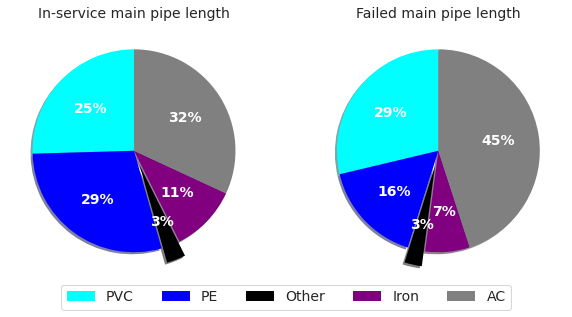

In [16]:
getMaterialDistribution(wPipesGISNfailures, True)


In [ ]:
def getMaterialFailureRate(predoMaterials, consM):
    
    #d = np.array([(0.16,0.04,0.32,np.nan), (0.15, 0.15,0.17, 0.03), (0.42, 0.06,0.51, np.nan)])
    #dfOtherAuthors = pd.DataFrame(data=d, columns=["AC","PVC","Iron",PE],
     #                             index=['US and Canada \n (Folkman,2018)',"UK \n (Barton et al.,2019)",
      #                                  'Australia \n (Gould et al.,2011)'])
    
    fig1, ax = plt.subplots(figsize=(6,3))

    groupMat = predoMaterials.groupby([WC.MATERIAL]).agg({ DAC.NUM_FAILURES: 'sum', WC.LENG: 'sum'}).copy()
    groupMat[DAC.FAILURE_RATE] = groupMat[DAC.NUM_FAILURES]/groupMat[WC.LENG]/6

    groupMat = groupMat.join(consM)
    
    #dfCombinated= pd.concat([dfOtherAuthors,groupMat[FAILURE_RATE].to_frame().T]).rename(
     #   index={FAILURE_RATE:'Auckland'})
    print(groupMat)
    
   # bars = #dfCombinated.plot.bar(ax=ax,color=groupMat['Color']) #coment for only auckland
    bars = groupMat[DAC.FAILURE_RATE].plot.bar(ax=ax, color=groupMat['Color']) #coment if want all countries
   
    ax = pu.removeTopRightFrame(ax)

    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', which='both')
    ax.set_ylabel(DAC.LBL_FAILURE_RATE)
    plt.xticks(rotation=0)
    #ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))

    fig1.savefig('Maps_Graph/MaterialAnalysis/'+ 'MateFailureRate' + '.png', dpi=200,bbox_inches='tight')

          Num of failures   Shape_Leng  Failures/Km/year   Color
MATERIAL                                                        
AC                 6001.0  3148.700121          0.317644    grey
PVC                3211.0  2336.606324          0.229036    cyan
Iron               1236.0  1077.988998          0.191097  purple
PE                 2128.0  2609.329925          0.135923    blue


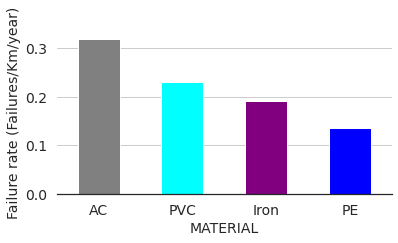

In [20]:

getMaterialFailureRate(predoMaterials,consCoM)

In [18]:
def getValidationYears():
    
    consYears = getMaterialConst()[['YearIni','YearFinal']]
    consYears = consYears[consYears.index.isin(MATERIALS_PREDOMI)]
    consYears['StartAge'] = 2021-consYears['YearIni'] 
    consYears['EndAge'] = 2021-consYears['YearFinal']
    consYears['EndAge'].replace(0, np.nan, inplace=True)
    consYears.index = pd.Categorical(consYears.index,categories= MATERIALS_PREDOMI)
    consYears=consYears.sort_index()
    
    return consYears

def getValidationDiams():
    
    consDiam = getMaterialConst()[['MinD','MaxD']]
    consDiam = consDiam[consDiam.index.isin(MATERIALS_PREDOMI)]
    consDiam.index = pd.Categorical(consDiam.index,categories= MATERIALS_PREDOMI)
    consDiam = consDiam.sort_index()
    
    return consDiam


def getMaterialColDistribution(inService,ws,consCoM, column, xlim, label2,validate,colV1, colV2,hs):

    pal=[consCoM[m] for m in MATERIALS_PREDOMI]
    
    g = sns.FacetGrid(inService, row=WC.MATERIAL, hue=WC.MATERIAL, aspect=8, height=1.3,xlim=xlim, palette=pal, sharex=True)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, column, bw_adjust=.5, fill=True, alpha=1, linewidth=1.5, weights=ws)
    g.map(sns.kdeplot, column, color="w", lw=2, bw_adjust=.5, weights=ws)
    g.map(plt.axhline, y=0, lw=2)
    
    #put Valid dots
    if validate is not None:
        cons = validate()
        for axe,i in zip(g.axes, cons.index):
            for ax in axe:
                ax.axvline(x=cons.loc[i,colV1],color="gold",lw=5,ymax=0.6) 
                ax.axvline(x=cons.loc[i,colV2], color="orange",lw=5,ymax=0.6)
    
    #STYLE------------------------------------------------------

    # Define and use a simple function to label the plot in axes coordinates
    def label(ax,x, color, label):

        ax = plt.gca()
        #include color=color if the labels should be colored
        ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)

    g.map(label, column) 
    g.set_xlabels(label2)
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=hs) #it matters where is placed!and it needs the right stype sns
    
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    return g

def getAgeDistribution():
    
    weights = inService.LENG.copy()
    #the limits where obtained ploting the box plot ans seeing the outliners start 
    # e.g. ax = sns.boxplot(x=CURRENT_AGE, y=MATERIAL, data=inService)
    g = getMaterialColDistribution(inService.copy(),weights,consCoM, DAC.CURRENT_AGE, (None,125), "Current Age (Years)",getValidationYears,"EndAge","StartAge",-.2)
    g.savefig('Maps_Graph/MaterialAnalysis/'+'AgeDisForMaterials' +'.png', dpi=200, bbox_inches='tight')
    
def getDiamDistribution():
    
    weights = inService.LENG.copy()
    #the limits where obtained ploting the box plot ans seeing the outliners start 
    # e.g. ax = sns.boxplot(x=NOM_DIA_MM, y=MATERIAL, data=inService)
    g = getMaterialColDistribution(inService.copy(),weights,consCoM, WC.NOM_DIA_MM, (None,310), DAC.DIAMETER,getValidationDiams,"MinD","MaxD",-.2)
    g.savefig('Maps_Graph/MaterialAnalysis/'+'DiamDisForMaterials' +'.png', dpi=200, bbox_inches='tight')

def getAgeAtFailureDistribution():
    
    #the limits where obtained ploting the box plot ans seeing the outliners start 
    # e.g. ax = sns.boxplot(x=AGE_FAILURE, y=MATERIAL, data=failuresPMaterials)
    g = getMaterialColDistribution(failuresPMaterials.copy(),None,consCoM, DAC.AGE_FAILURE, (None,125), "Age at failure (Years)",getValidationYears,"EndAge","StartAge",0)
    g.savefig('Maps_Graph/MaterialAnalysis/'+'AgeDisForFailedMaterials' +'.png', dpi=200, bbox_inches='tight')



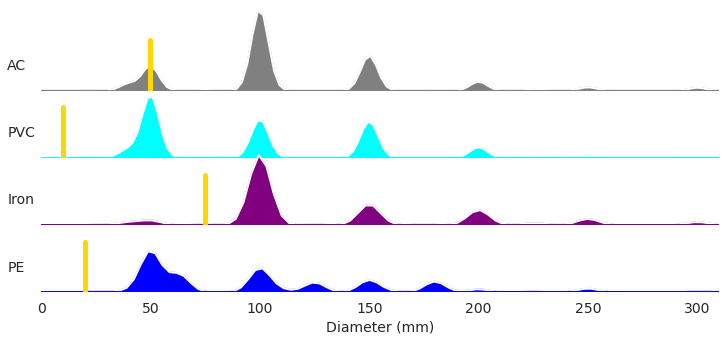

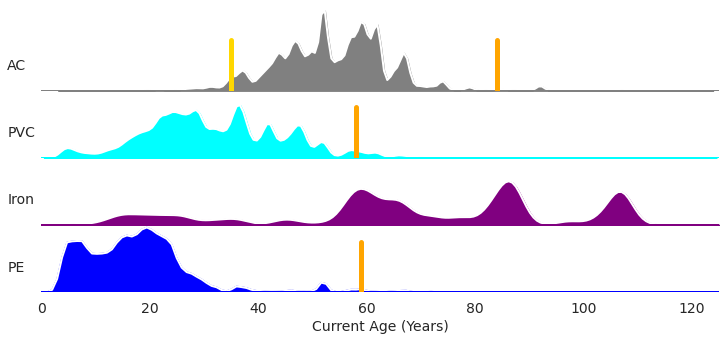

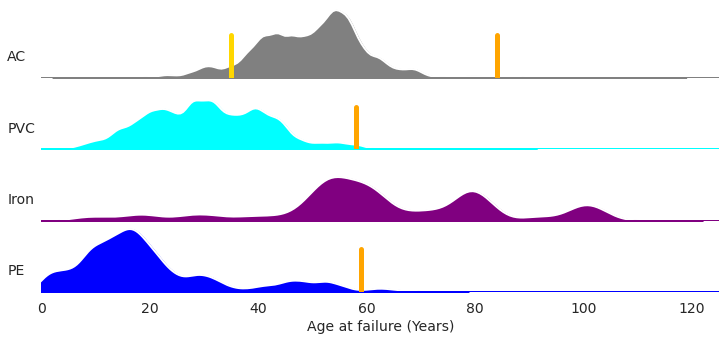

In [19]:
getDiamDistribution()
getAgeDistribution()
getAgeAtFailureDistribution()

# ------------EXTRA CHECK--------------------------

In [13]:
WMNFromAssetRecords = gf.getAssetsRecords()
failuresWithPipesInGIS, wPipesGIS = gf.getFailuresWithPipes(mainFailures,WMNFromAssetRecords.index)
wPipesGIS[WC.NOM_DIA_MM] = pd.to_numeric(wPipesGIS[WC.NOM_DIA_MM],errors='coerce')
wPipesGIS[DAC.CURRENT_AGE] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGIS[WC.INSTALLED])).astype('<m8[Y]')
	
	
wPipesGISInSEr = wPipesGIS[wPipesGIS[WC.STATUS] == WC.INSERV_PROCESS].copy()

wPipesGISCI= wPipesGISInSEr[wPipesGISInSEr[WC.MATERIAL].isin([WC.CI,WC.GI,WC.CLCI,WC.DI,WC.CLDI,WC.ELCI])].copy()

wPipesGISCISmallDiam = wPipesGISCI[wPipesGISCI[WC.NOM_DIA_MM]<75].copy()


total = wPipesGISCISmallDiam[WC.LENG].sum()
group=wPipesGISCISmallDiam.groupby([WC.MATERIAL]).agg({ WC.LENG: 'sum',DAC.CURRENT_AGE: 'mean'}).copy()
group[DAC.LEN_PERC] = group[WC.LENG]*100/total
group.sort_values(by=DAC.LEN_PERC)

Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


,Shape_Leng,Age Today,%Length
MATERIAL,,,
ELCI,12.345866,41.000000,0.022011
CLDI,94.299029,35.000000,0.168122
DI,700.617449,28.722222,1.249105
CLCI,1168.686934,80.584416,2.083609
CI,8273.126548,77.813131,14.749851
GI,45840.483843,67.080645,81.727302


# ------------End EXTRA CHECK--------------------------

In [14]:
sns.set_style("ticks")

In [21]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK[WC.LENG].sum()," from original ", "%.2f" % df[WC.LENG].sum())
    
    return dfOK

def groupByFactor(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    #put into ranges and group by
    if col is not None:
        dfOK= putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol)
    else:
        dfOK= df[~pd.isna(df[colRanges])].copy()
        
    dfGroup= dfOK.groupby([WC.MATERIAL,colRanges]).agg({WC.LENG:sum, DAC.NUM_FAILURES:sum}).copy()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup[DAC.FAILURE_RATE]= dfGroup[DAC.NUM_FAILURES]/dfGroup[WC.LENG]/6 
    #remove values with less than the 2% of that material
    dfGroup[DAC.FAILURE_RATE]= dfGroup[DAC.FAILURE_RATE].where(dfGroup['%'] > MAX_PERCEN_TOSHOW, np.nan)
    
    return dfGroup

def getMaterialColRangeDis(df,col,rot=0,banc=(0.5, -0.13),percentage=True):
    
    #if does not have ticks then
    #sns.set_style("sticks")

    #transforming the data and getting the %
    if percentage:
        df['% of total length'] = df[WC.LENG] *100 / df[WC.LENG].sum()
        varDisplay, varName = '% of total length','% of total length'
    else:
        varDisplay, varName= WC.LENG ,"Length (km)"

    materialsColumns = df.reset_index().pivot(index=col, columns=WC.MATERIAL, values=varDisplay)

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar( ax= ax, color= pal, rot=rot,alpha=0.7,stacked=True)
   
    #styling
    ax = pu.removeTopRightFrame(ax)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', which='both')
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=banc)
    ax.set_ylabel(varName, multialignment='center');
    
    return fig1

def getMaterialDiamRangeDis():
    
    isSerGroupDiam= groupByFactor(inService.copy(),DAC.DIAMETER,WC.NOM_DIA_MM,Diam_bins,DRange_labels,None,None,None)
    
    fig1=getMaterialColRangeDis(isSerGroupDiam,WC.DIAMETER)
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'MaterialDiamRangeDis' +'.png', dpi=200, bbox_inches='tight')

def getMaterialAgeRangeDis():
    
    isSerGroupAge= groupByFactor(inService.copy(),DAC.DIAMETER,DAC.CURRENT_AGE,Age_Range,AgeR_labels,getValidationYears,"EndAge","StartAge")
    
    fig1=getMaterialColRangeDis(isSerGroupAge,DAC.LBL_CURRENT_AGE)
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'MaterialAgeRangeDis' +'.png', dpi=200, bbox_inches='tight')




(Main in service) Pipe length with valid  Age Today  8382.04  from original  8569.67
(Main in service) Pipe length with valid  NOM_DIA_MM  8529.09  from original  8569.67


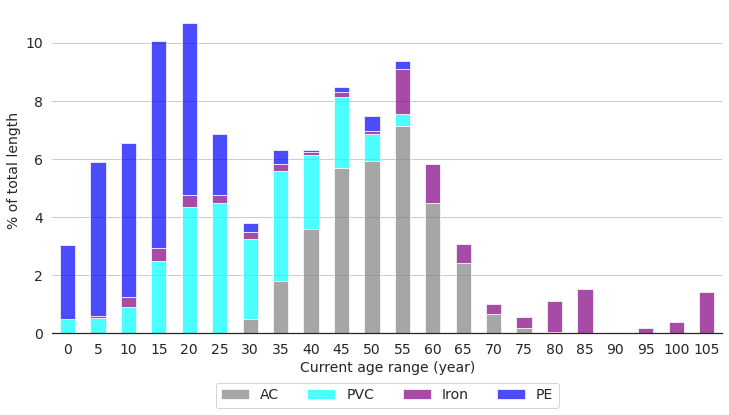

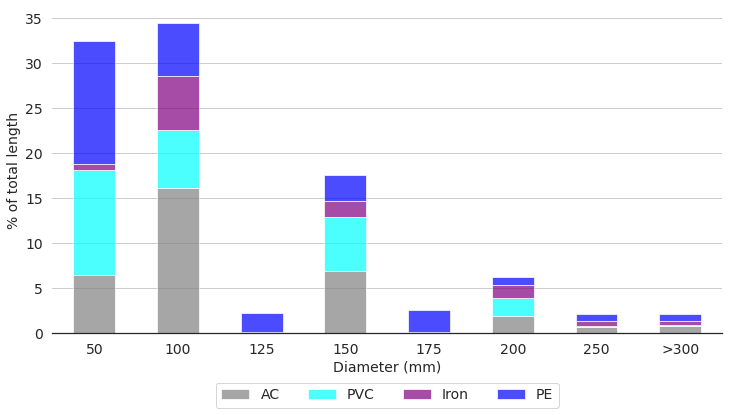

In [22]:
getMaterialAgeRangeDis()
getMaterialDiamRangeDis()

# Extra with service lines ------------------------------------------------------------

(Main in service) Pipe length with valid  NOM_DIA_MM  8529.09  from original  8569.67


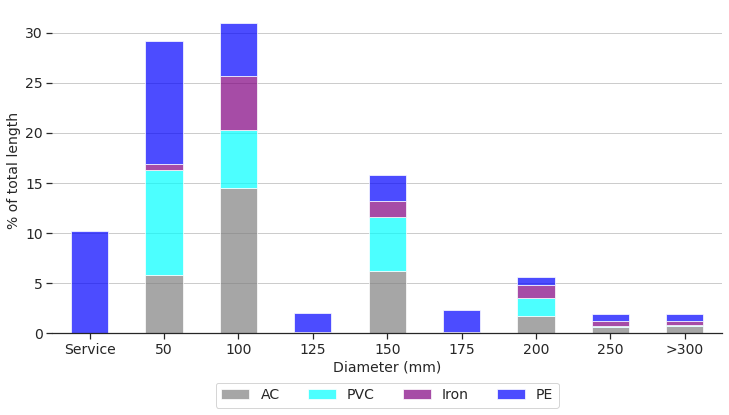

In [17]:
def getMaterialDiamRangeDisSERV():
    
    isSerGroupDiam= groupByFactor(inService.copy(),DAC.DIAMETER,WC.NOM_DIA_MM,Diam_bins,DRange_labels,None,None,None)
    
    servP=pd.DataFrame([[WC.PE,"Service",974, 77956, None,13.3]], columns=[WC.MATERIAL,DAC.DIAMETER,WC.LENG,DAC.NUM_FAILURES,"%",DAC.FAILURE_RATE], index=[0])

    isSerGroupDiamS= isSerGroupDiam.reset_index().append(servP).copy()
    isSerGroupDiamS.MATERIAL = pd.Categorical(isSerGroupDiamS.MATERIAL,categories= MATERIALS_PREDOMI)
    listAum= ["Service"] + DRange_labels
    isSerGroupDiamS[DAC.DIAMETER] = pd.Categorical(isSerGroupDiamS[DAC.DIAMETER],categories= listAum)
    isSerGroupDiamS= isSerGroupDiamS.sort_values(by=[WC.MATERIAL,DAC.DIAMETER])
    
    isSerGroupDiamS=isSerGroupDiamS.groupby([WC.MATERIAL,DAC.DIAMETER]).agg({WC.LENG:sum, DAC.NUM_FAILURES:sum}).copy()
    
    fig1=getMaterialColRangeDis(isSerGroupDiamS,DAC.DIAMETER,0,(0.5, -0.13),True)
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'MaterialDiamRangeDisSerV' +'.png', dpi=200, bbox_inches='tight')

getMaterialDiamRangeDisSERV()

# Ends extra---------------------------------------------------------------------------

In [19]:
def getMaterialColBurstRate(dfGroup,col):

    materialsColumns = dfGroup.reset_index().pivot(index=col, columns=WC.MATERIAL, values='Failures/Km/year')

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot(ax= ax, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=12)
    ax = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=5)
    
    #remove second legen
    lines, labels = ax.get_legend_handles_labels()
    
    #styling
    ax = pu.removeTopRightFrame(ax)
    ax.legend(lines[4:], labels[4:],ncol=4, facecolor='white',fontsize=14)
    ax.set_ylim(bottom=0)
    
    ax.set_ylabel(DAC.LBL_FAILURE_RATE, multialignment='center');

    return fig1 , ax

def getBurstRateVsAge():

    isSerGroupAge= groupByFactor(inService,DAC.LBL_CURRENT_AGE,DAC.CURRENT_AGE,Age_Range,AgeR_labels,getValidationYears,"EndAge","StartAge")
    
    fig1, ax =getMaterialColBurstRate(isSerGroupAge,DAC.LBL_CURRENT_AGE)
    loc = plticker.MultipleLocator(base=2.5)
    ax.xaxis.set_minor_locator(loc)
    ax.grid(axis='x', which='both')

    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsAge' +'.png', dpi=200, bbox_inches='tight')


def getBurstRateVsDiameter():
    
    isSerGroupDiam= groupByFactor(inService,DAC.DIAMETER,WC.NOM_DIA_MM,Diam_bins,DRange_labels,None,None,None)
    print(isSerGroupDiam)
    
    fig1, ax =getMaterialColBurstRate(isSerGroupDiam,DAC.DIAMETER)
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsDiameter' +'.png', dpi=200, bbox_inches='tight')


(Main in service) Pipe length with valid  Age Today  8410.51  from original  8569.67
(Main in service) Pipe length with valid  NOM_DIA_MM  8529.09  from original  8569.67
                         Shape_Leng  Num of failures      %  Failures/Km/year
MATERIAL Diameter (mm)                                                       
AC       50              548.537022           1700.0  19.51          0.516525
         100            1380.674669           2597.0  49.11          0.313494
         125               0.611432              0.0   0.02               NaN
         150             589.301154            771.0  20.96          0.218055
         175               0.943537              0.0   0.03               NaN
         200             167.023143            139.0   5.94          0.138703
         250              59.881296             37.0   2.13          0.102982
         >300             64.576780             39.0   2.30          0.100655
PVC      50              997.237745           182

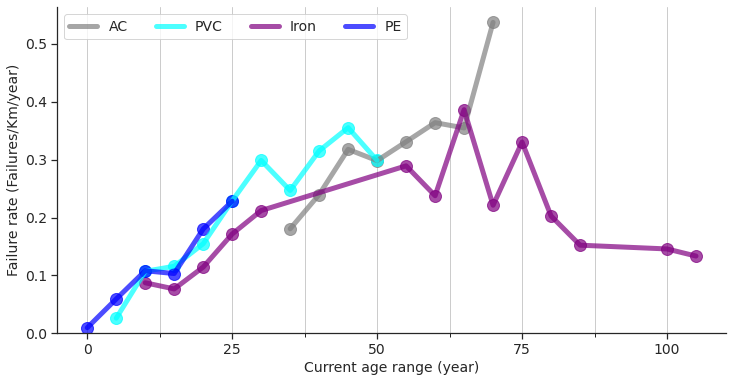

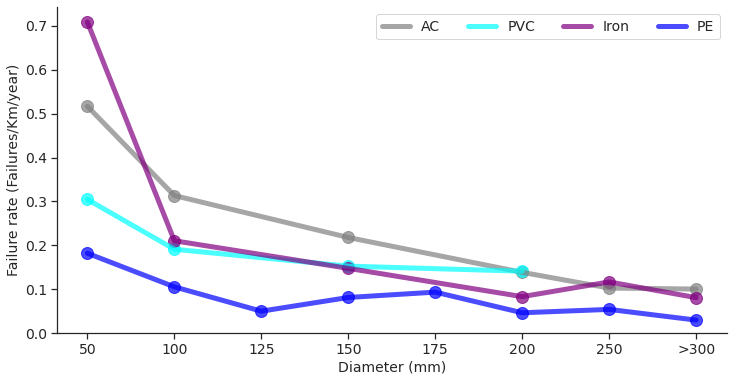

In [20]:
getBurstRateVsAge()
getBurstRateVsDiameter()


(Main in service) Pipe length with valid  NOM_DIA_MM  8529.09  from original  8569.67
(Main in service) Pipe length with valid  Age Today  2865.68  from original  2946.46
(Main in service) Pipe length with valid  Age Today  1870.49  from original  1913.47
(Main in service) Pipe length with valid  Age Today  519.96  from original  529.69
(Main in service) Pipe length with valid  Age Today  360.87  from original  370.41


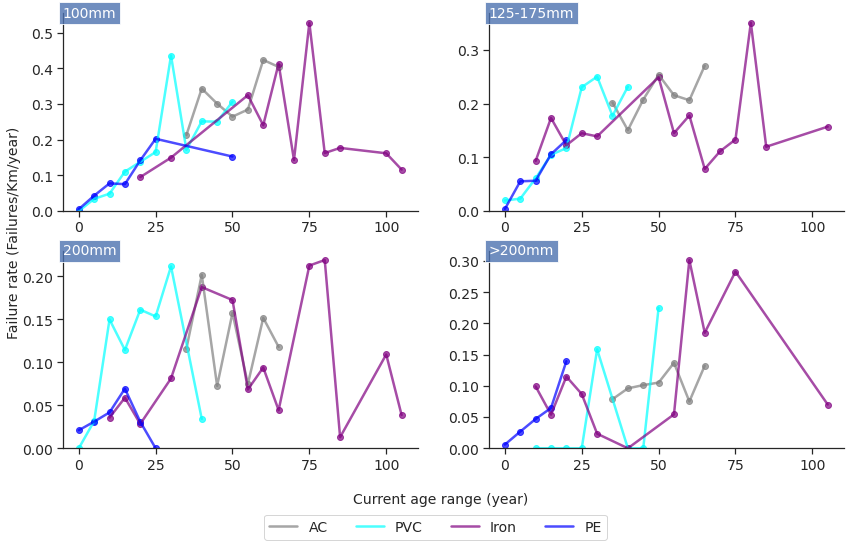

In [19]:
#def getBurstRateVsAgePerDiam():
    
Diam_bins2 = [25, 75, 115, 190, 225,800]
DRange_labels2 = ['50','100', '125-175','200','>200']
    
fig1, axs  = plt.subplots(2,2,figsize=(14,8))
    
inServiceDiamR= putInRanges(inService.copy(),"DiamGrouped",WC.NOM_DIA_MM,Diam_bins2,DRange_labels2,None,None,None)

axes = axs[0].tolist()+axs[1].tolist()

for diam, ax in zip(DRange_labels2[1:],axes):
        
    inServiceDiamRi = inServiceDiamR[inServiceDiamR['DiamGrouped']== diam].copy()
        
    isSerGroupAge= groupByFactor(inServiceDiamRi,DAC.LBL_CURRENT_AGE,DAC.CURRENT_AGE,Age_Range,AgeR_labels,getValidationYears,"EndAge","StartAge")
    
    materialsColumns = isSerGroupAge.reset_index().pivot(index=DAC.LBL_CURRENT_AGE, columns=WC.MATERIAL, values=DAC.FAILURE_RATE)

    #start of the graph
    ax = materialsColumns.plot(ax= ax, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=6)
    ax = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=2.5)
        
    #styling
    ax = pu.removeTopRightFrame(ax)
    ax.set_ylim(bottom=0)
    ax.legend().remove()
    ax.set_xlabel("")
    
    ax.text(0, 1, diam + "mm", horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='b', alpha=0.8),c='1')

    
#remove second legen
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[4:], labels[4:],ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(-0.15, -0.3))
fig1.text(0.5, 0.03, DAC.LBL_CURRENT_AGE, ha='center')
fig1.text(0.07, 0.5, DAC.LBL_FAILURE_RATE, va='center', rotation='vertical')

fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsAgeNDiam' +'.png', dpi=200, bbox_inches='tight')


# Extra with service lines ------------------------------------------------------------

(Main in service) Pipe length with valid  NOM_DIA_MM  8529.09  from original  8569.67


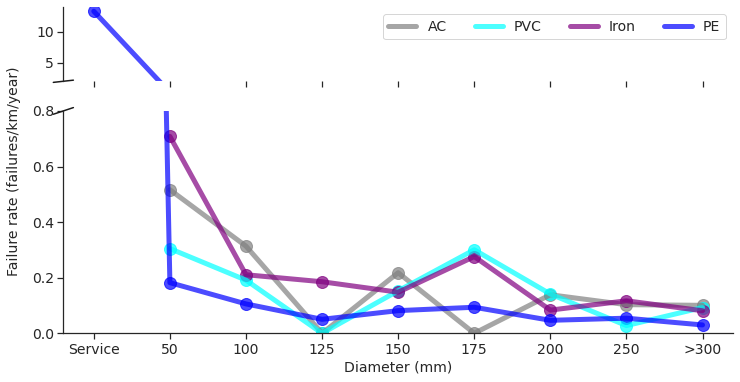

In [20]:
def getBurstRateVsDiameterSERV():
    
    isSerGroupDiam= groupByFactor(inService,DAC.DIAMETER,WC.NOM_DIA_MM,Diam_bins,DRange_labels,None,None,None)
    
    servP=pd.DataFrame([[WC.PE,"Service",974, 77956, None,13.3]], columns=[WC.MATERIAL,DAC.DIAMETER,WC.LENG,DAC.NUM_FAILURES,"%","Failures/Km/year"], index=[0])

    isSerGroupDiamS= isSerGroupDiam.reset_index().append(servP).copy()
    isSerGroupDiamS.MATERIAL = pd.Categorical(isSerGroupDiamS.MATERIAL,categories= MATERIALS_PREDOMI)
    listAum= ["Service"] + DRange_labels
    isSerGroupDiamS[DAC.DIAMETER] = pd.Categorical(isSerGroupDiamS[DAC.DIAMETER],categories= listAum)
    isSerGroupDiamS= isSerGroupDiamS.sort_values(by=[WC.MATERIAL,DAC.DIAMETER]).copy()
    
    isSerGroupDiamS=isSerGroupDiamS.groupby([WC.MATERIAL,DAC.DIAMETER]).agg({WC.LENG:sum, DAC.NUM_FAILURES:sum}).copy()
    isSerGroupDiamS[DAC.FAILURE_RATE]=isSerGroupDiamS[DAC.NUM_FAILURES]/isSerGroupDiamS[WC.LENG]/6
    
    dfGroup=isSerGroupDiamS
    col=DAC.DIAMETER
    
    materialsColumns = dfGroup.reset_index().pivot(index=col, columns=WC.MATERIAL, values=DAC.FAILURE_RATE)

    #start of the graph
    fig1, (ax,ax2)  = plt.subplots(2,figsize=(12,6),sharex=True,gridspec_kw={'height_ratios': [1, 3]})
    
    ax = materialsColumns.plot(ax= ax, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=12)
    ax = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=5)
    
    ax2 = materialsColumns.plot(ax= ax2, color=pal, rot=0, alpha=0.7, marker='o',linewidth=0, ms=12)
    ax2 = materialsColumns.interpolate(method='linear',limit_area='inside').plot(ax= ax2, color=pal, rot=0, alpha=0.7, linewidth=5) 
    
    ax.set_ylim(bottom= 2)  # outliers only
    ax2.set_ylim(0, 0.8)
    
    ax, ax2= pu.createBrokenAxisEffectNoRight(ax,ax2)
    
    #remove second legen
    lines, labels = ax.get_legend_handles_labels()
    
    #styling
    ax = pu.removeTopRightFrame(ax)
    ax2 = pu.removeTopRightFrame(ax2)
    ax.legend(lines[4:], labels[4:],ncol=4, facecolor='white',fontsize=14)
    ax2.legend().remove()
    fig1.text(0.06, 0.5, DAC.LBL_FAILURE_RATE, va='center', rotation='vertical')
    
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsDiameterSERV' +'.png', dpi=200, bbox_inches='tight')


getBurstRateVsDiameterSERV()
    
    

# Ends extra---------------------------------------------------------------------------

In [13]:
def getMaterialAGEBurstRateBAR(dfGroup,col):

    materialsColumns = dfGroup.reset_index().pivot(index=col, columns=WC.MATERIAL, values=DAC.FAILURE_RATE)

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar(ax= ax, color=pal, rot=0, alpha=0.7)
   # ax = materialsColumns.interpolate(method='linear').plot(ax= ax, color=pal, rot=0, alpha=0.7, linewidth=5)
    
    #remove second legen
    #lines, labels = ax.get_legend_handles_labels()
    
    #styling
    ax = pu.removeTopRightFrame(ax)
    ax.legend(ncol=4, facecolor='white',fontsize=14)
    ax.set_ylim(bottom=0)
    
    ax.set_ylabel(DAC.LBL_FAILURE_RATE, multialignment='center');

    return fig1 , ax

def getBurstRateVsAgeBAR():
    
    isSerGroupAge= groupByFactor(inService,DAC.LBL_CURRENT_AGE,DAC.CURRENT_AGE,Age_Range[:13],AgeR_labels[:12],getValidationYears,"EndAge","StartAge")
    
    fig1, ax =getMaterialAGEBurstRateBAR(isSerGroupAge,DAC.LBL_CURRENT_AGE)
    ax.grid(axis='y', which='both')
  
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsAgeBAR' +'.png', dpi=200, bbox_inches='tight')




(Main in service) Pipe length with valid  Age Today  7193.71  from original  8569.67


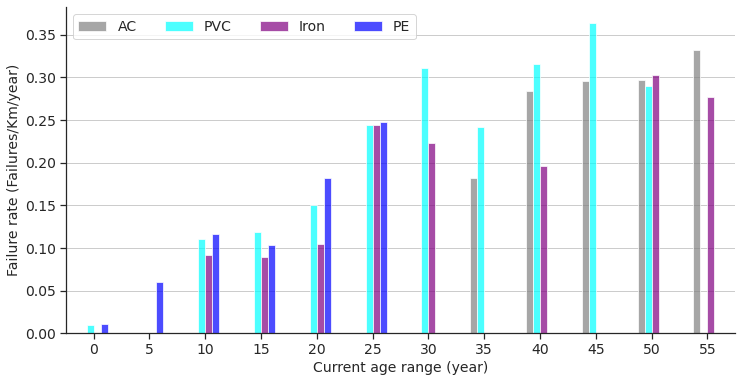

In [22]:
getBurstRateVsAgeBAR()

In [47]:
def getNumFailuresPerMonth(failuresPMat,predoMat):
    
    #Get a table with the number of failures per month in the 6 years segregated by material
    failuresPMaterials['Failure year']= pd.to_datetime(failuresPMat[WC.ADDDTTM]).dt.year
    failuresPMaterials['Failure month']= pd.to_datetime(failuresPMat[WC.ADDDTTM]).dt.month

    failureGroupMonthly=failuresPMaterials.groupby([WC.MATERIAL,"Failure year","Failure month"]).agg({WC.ADDDTTM:'count'})

    failureGroupMonthly.rename(columns={WC.ADDDTTM:'Number of failures'},inplace=True)
    failureGroupMonthly=failureGroupMonthly.reset_index()
    failureGroupMonthly["Month"]= failureGroupMonthly["Failure month"].apply(lambda x: calendar.month_abbr[x])
    
    pipeLeng= predoMat.groupby([WC.MATERIAL]).agg({WC.LENG:sum }).copy()
    failureGroupMonthly= failureGroupMonthly.join(pipeLeng,on=WC.MATERIAL)
    
    failureGroupMonthly['Failure rate (Failures/km/month)']= failureGroupMonthly['Number of failures']/failureGroupMonthly[WC.LENG]
    
    return failureGroupMonthly


def numberFailurePerMonth(failures, pipes):

    failureGroupMonthly= getNumFailuresPerMonth(failures,pipes).copy()
 
    fig1, ax  = plt.subplots(figsize=(12,6))

    # Plot the responses for different events and regions

    ax = sns.lineplot(x="Month", y='Failure rate (Failures/km/month)',  hue=WC.MATERIAL, data=failureGroupMonthly,ax=ax, palette=pal)
    ax.grid(axis='y', which='both')
    ax.legend(ncol=6, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))

    sns.despine(left=True)
    
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'FailureRatePerMonth' +'.png', dpi=200, bbox_inches='tight')



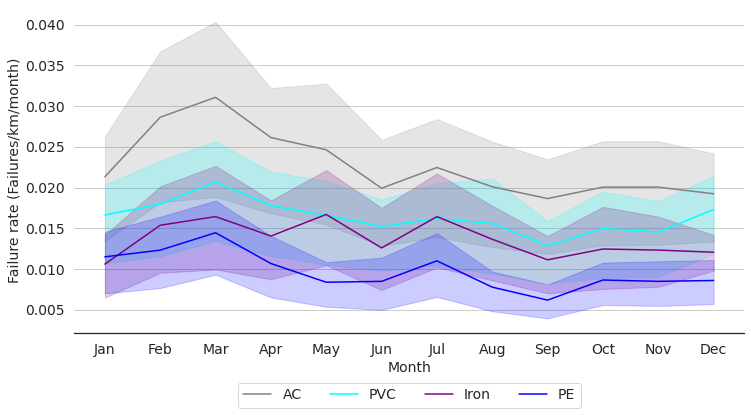

In [30]:
numberFailurePerMonth(failuresPMaterials.copy(),predoMaterials.copy())

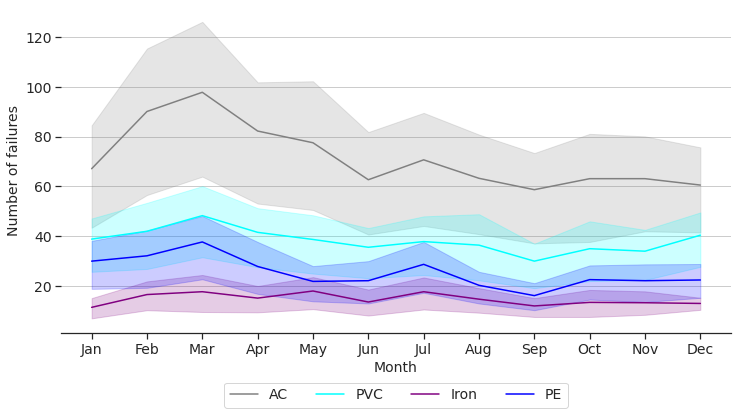

In [24]:
numberFailurePerMonth(failuresPMaterials.copy())

# Regression values ------------------------------------------------------------

In [24]:
def runRegression(dfm,m):
    
    X = dfm[DAC.CURRENT_AGE].copy()
    y = dfm[DAC.FAILURE_RATE].copy()
    w = dfm[WC.LENG].copy()
            
    X = sm.add_constant(X)

    model = sm.WLS(y, X,weights=w).fit() 
        
    print(m, " coef: ", model.params[DAC.CURRENT_AGE], 
                    "std: ", model.bse[DAC.CURRENT_AGE], 
                    "pvalue: " , model.pvalues[DAC.CURRENT_AGE])

def getRegressionValuesPerMaterial(df):
      
    isSerRanges= putInRanges(df,DAC.LBL_CURRENT_AGE,DAC.CURRENT_AGE,Age_Range,AgeR_labels,getValidationYears,"EndAge","StartAge")
    isSerRanges[DAC.FAILURE_RATE] = isSerRanges[DAC.NUM_FAILURES]/isSerRanges[WC.LENG]/6
    
    for m in MATERIALS_PREDOMI:
        
        dfm= isSerRanges[isSerRanges[WC.MATERIAL]==m].copy()
        
        if m == DAC.IRON:
            
            dfm= isSerRanges[isSerRanges[WC.MATERIAL]==m].copy()
            
            dfLess= dfm[dfm[DAC.CURRENT_AGE]<=70].copy()
            dfMore= dfm[dfm[DAC.CURRENT_AGE]>70].copy()
            
            runRegression(dfLess,m+"Less")
            runRegression(dfMore,m+"More")
        
        else:
            
            runRegression(dfm,m)
        
           

In [25]:
getRegressionValuesPerMaterial(inService.copy())

(Main in service) Pipe length with valid  Age Today  8410.56  from original  8569.67
AC  coef:  0.005311715787593842 std:  0.0008429969051816673 pvalue:  2.9818998292435633e-10
PVC  coef:  0.006768828301389472 std:  0.000568135674545952 pvalue:  1.1352661679780253e-32
IronLess  coef:  0.004464621471566239 std:  0.0008095860935358339 pvalue:  3.545719040571578e-08
IronMore  coef:  -0.0030071596908252487 std:  0.0013768877212193107 pvalue:  0.02897754838294865
PE  coef:  0.009220247884965664 std:  0.0006307461050461924 pvalue:  2.5939929261325575e-48


In [18]:
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182569 entries, 21006974 to 28753970
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Shape_Leng                182569 non-null  float64 
 1   STATUS                    182569 non-null  object  
 2   NOM_DIA_MM                182569 non-null  float64 
 3   MATERIAL                  182569 non-null  category
 4   INSTALLED                 182569 non-null  object  
 5   Num of failures           182569 non-null  float64 
 6   Age Today                 182569 non-null  float64 
 7   Current age range (year)  182569 non-null  category
dtypes: category(2), float64(4), object(2)
memory usage: 10.1+ MB


## Scatter diameter vs Age -------------------------------------------

In [14]:
def getAgeDiamScatter(df):
    
    Age_Range2 = np.arange(0, 100, 20).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 80, 20).tolist()]
    
    col=WC.NOM_DIA_MM
    col2=DAC.CURRENT_AGE
    colRanges=DAC.DIAMETER
    colRanges2='Current age (years)'
    bins=Diam_bins
    bins2=Age_Range2
    labels=DRange_labels
    labels2=AgeR_labels2
    
    
    #put into ranges and group by    
    dfOK= putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2)
        
    dfGroup= dfOK.groupby([WC.MATERIAL,colRanges,colRanges2]).agg({WC.LENG:sum, DAC.NUM_FAILURES:sum, col2: 'mean',col: 'mean'}).copy()

    dfGroup= dfGroup.dropna(subset=[WC.LENG]).copy()
    assert dfOK[DAC.NUM_FAILURES].sum() == dfGroup[DAC.NUM_FAILURES].sum() 
    
    dfGroup=dfGroup.reset_index().copy()
    
    #regressions
    g = sns.lmplot(data=dfGroup,x=col, y=col2, hue=WC.MATERIAL,
                       height=6, aspect=1.8, legend=False,robust=True, truncate=True,
                       scatter_kws={'alpha': 0.5,'s':80}, line_kws={'lw': 5,'alpha': 0.7})
        
    sns.despine(left=True)
    plt.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))
    
    #g.axes[0][0].set_xlabel(xlabel)
    #g.axes[0][0].set_ylabel("Current age (years)")
    g.axes[0][0].grid(axis='y', which='both')
    #g.axes[0][0].set_title(material,fontsize=14 )
    g.set(ylim=(0, None))
        
    #g.fig.savefig('Maps_Graph/PressureAnalysis/'+'BurstRateVsPressReg'+label+m+'.png', dpi=200, bbox_inches='tight')



Pipe length with valid  NOM_DIA_MM and  Age Today 8625.53  from original  9172.63


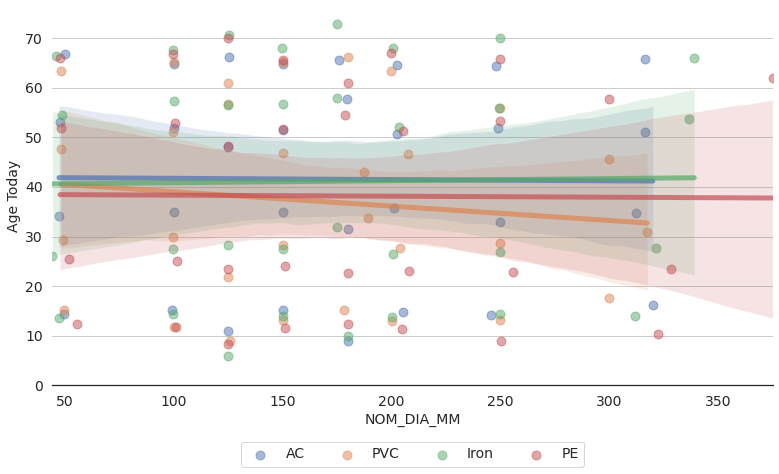

In [76]:
getAgeDiamScatter(predoMaterials.copy())

In [43]:
#I created this ones originally for pressure analysis

def putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    df[colRanges2]= pd.cut(df[col2], bins=bins2, labels=labels2)
    
    #remove invalid values (nulls)----------------------------------
    dfOK= df.dropna(subset=[colRanges, colRanges2]).copy()
     
    print("Pipe length with valid ",col+" and ", col2,"%.2f" % dfOK[LENG].sum()," from original ", "%.2f" % df[LENG].sum())
    
    return dfOK

def groupByTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2):
    
    #put into ranges and group by    
    dfOK= putInRangesTwoFactors(df,colRanges,col,bins,labels,colRanges2,col2,bins2,labels2)
        
    dfGroup= dfOK.groupby([MATERIAL,colRanges,colRanges2]).agg({LENG:sum, NUM_FAILURES:sum, col2: 'mean'}).copy()

    dfGroup= dfGroup.dropna(subset=[LENG]).copy()
    assert dfOK[NUM_FAILURES].sum() == dfGroup[NUM_FAILURES].sum()
    
    #put percentage of shape leng per material
    dfGroup['%']= 0
    dfGroup['%']= dfGroup.groupby(level=0).transform(lambda x: (x*100 / x.sum()).round(2))
    
    dfGroup[FAILURE_RATE]= dfGroup[NUM_FAILURES]/dfGroup[LENG]/6 
    
    return dfGroup

def getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,var):
    
    regres=[]
    
    for d in diamColumns.columns.tolist():
        
        y= diamColumns[d].dropna()
        X= diamColumnsMeanPress[d][diamColumnsMeanPress[d].index.isin(y.index)]
        w= diamColumnsLeng[d][diamColumnsLeng[d].index.isin(y.index)]
            
        if (not any(np.isnan(X)) and (len(y)>2)):
          
            X = sm.add_constant(X)

            model = sm.WLS(y, X,weights=w).fit() 

            #material, diameter, slope, intercept, std dev, p-value of the slope, rsquared
            regres.append([d,model.params[d], model.params['const'], 
                           model.bse[d], model.pvalues[d], model.rsquared])
    
    df=pd.DataFrame(regres, columns =[var, 'Slope', 'Intercept', 
                                      'Std dev', 'Slope P-value', 'Rsquared'])
    
    df.to_csv('Output/Regressions/'+"AgeVsFailR"+var+m+'.csv') 
    
def getBurstRateVarPerColScatter(df,xlabel,material,m,pal,col,groupbyRang,label):
    
    #df=df[df[DIAMETER]!='>=200'] uncomment When Iron throws error
    
    #regressions
    g = sns.lmplot(data=df,x=col, y=DAC.FAILURE_RATE, hue=groupbyRang,
                       height=6, aspect=1.8, palette=pal,legend=False,robust=True, truncate=True,
                       scatter_kws={'alpha': 0.5,'s':80}, line_kws={'lw': 5,'alpha': 0.7})
        
    sns.despine(left=True)
    plt.legend(ncol=6, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.13))

    
    g.axes[0][0].set_xlabel(xlabel)
    g.axes[0][0].set_ylabel(DAC.LBL_FAILURE_RATE)
    g.axes[0][0].grid(axis='y', which='both')
    g.axes[0][0].set_title(material,fontsize=14 )
    g.set(ylim=(0, None))

    g.fig.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsAge'+label+m+'.png', dpi=200, bbox_inches='tight')


        

#modificated!!!
def getBurstRatePressMatPerRanges(m,failures,lengths,name,pal,numCat,var,col,l,r):
    
     #start of the graph
    fig1, [ax2,ax]  = plt.subplots(2,figsize=(12,8),sharex=True, gridspec_kw={'height_ratios': [1, 3]})

    ax = failures.plot(ax= ax, rot=0, alpha=0.5, marker='o',linewidth=5, ms=12,color=pal)
    ax = failures.interpolate(method='linear',limit_area='inside').plot(ax= ax, rot=0, alpha=0.7, linewidth=5, color=pal)
        
    #styling
    ax = pu.removeTopRightFrame(ax)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[numCat:], labels[numCat:],ncol=col,fontsize=14,facecolor='white',loc='upper center',bbox_to_anchor=(.5,-.13))
    ax.set_ylim(bottom=0)
    ax.set_ylabel(DAC.FAILURE_RATE_LABEL, multialignment='center');
    ax.grid(axis='y', which='both')
        
    #Bar plot on top
    ax2 = lengths.plot.bar( ax= ax2, color= pal, alpha=0.7)

    #styling
    ax2 = pu.removeTopRightFrame(ax2)
    ax2.legend().remove()
    ax.set_xlim(l,r)
    ax2.set_xlim(l,r)
    ax2.yaxis.set_minor_locator(plticker.MultipleLocator(100))
    ax2.grid(axis='y', which='both')
    ax2.set_ylabel("Pipe length (Km)", multialignment='center');
        
    ax2.set_title(name,fontsize=14 )
    plt.subplots_adjust(hspace=0.1)
        
    fig1.savefig('Maps_Graph/MaterialAnalysis/'+'BurstRateVsAge'+var+m +'.png', dpi=200, bbox_inches='tight')
       
#modificated!!!
def getBurstRateColMatPer(df,colRanges,col,colBins,colLabels,colRanges2,col2,colBins2,colLabels2,label):
    
    # division constants
    numCat=len(colLabels2)
    names = getMaterialConst()['NAME']
    
    #Style constants
    pale= cmlib.viridis(np.linspace(0, 1, numCat+1))
      
    dfGroupDiam= groupByTwoFactors(df,colRanges2,col2,colBins2,colLabels2,
                                      colRanges,col,colBins,colLabels)
    
    #remove values with less than the 1% of that material
    dfGroupDiam[DAC.FAILURE_RATE]= dfGroupDiam[DAC.FAILURE_RATE].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam[WC.LENG]= dfGroupDiam[WC.LENG].where(dfGroupDiam['%'] > MAX_PERCEN_TOSHOW, np.nan)
    dfGroupDiam= dfGroupDiam.reset_index().copy()
    
    #hardcored limits
    for m,l,r in zip(MATERIALS_PREDOMI,[7,2,1.5,-0.5],[14,11,21.5,6]):
        
        dfG= dfGroupDiam[dfGroupDiam[WC.MATERIAL]==m].copy()
        
        diamColumns=dfG.pivot(index=colRanges, columns=colRanges2, values=DAC.FAILURE_RATE).sort_index().copy()
        diamColumnsLeng=dfG.pivot(index=colRanges, columns=colRanges2, values=WC.LENG).sort_index().copy()
        diamColumnsMeanPress=dfG.pivot(index=colRanges, columns=colRanges2, values=col).sort_index().copy()
        
        #graph in ranges
        #getBurstRatePressMatPerRanges(m,diamColumns,diamColumnsLeng,names[m],pale,numCat,label,numCat,l,r)
        
        #getRegressionLines(m,diamColumns,diamColumnsMeanPress,diamColumnsLeng,label)
        
        getBurstRateVarPerColScatter(dfG,colRanges,names[m],m,pale,col,colRanges2,label)
        
        
def getAgeFailureGraphs(df):
    
    Age_Range2 = np.arange(0, 115, 10).tolist()
    AgeR_labels2 = [str(i) for i in np.arange(0, 105, 10).tolist()]
    Diam_bins2 = [25, 75, 115, 190, 800]
    DRange_labels2 = ['50','100', '125-175','>=200']

    getBurstRateColMatPer(df,"Current age (years)",CURRENT_AGE,Age_Range,AgeR_labels,
                          DIAMETER,NOM_DIA_MM,Diam_bins2,DRange_labels2,"Diam&Age")


    

Pipe length with valid  NOM_DIA_MM and  Age Today 9094.18  from original  9172.63


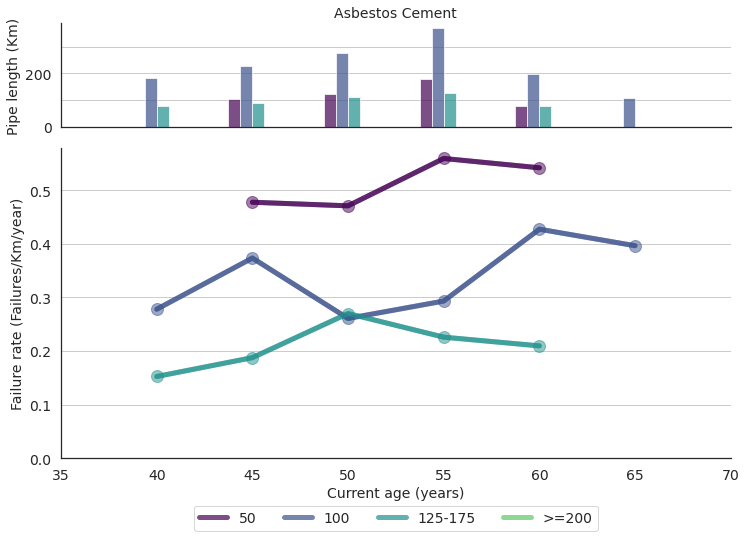

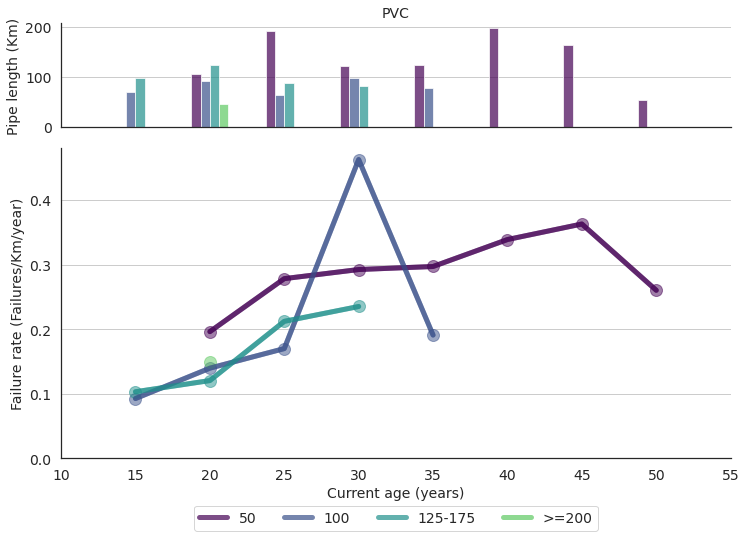

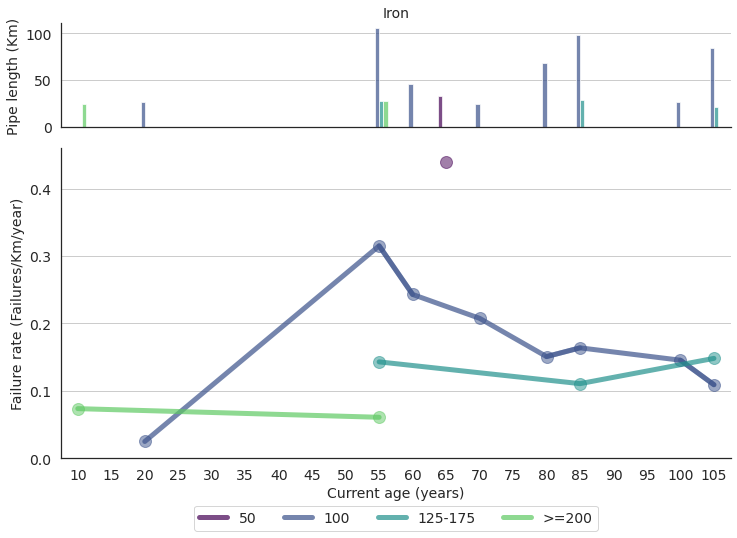

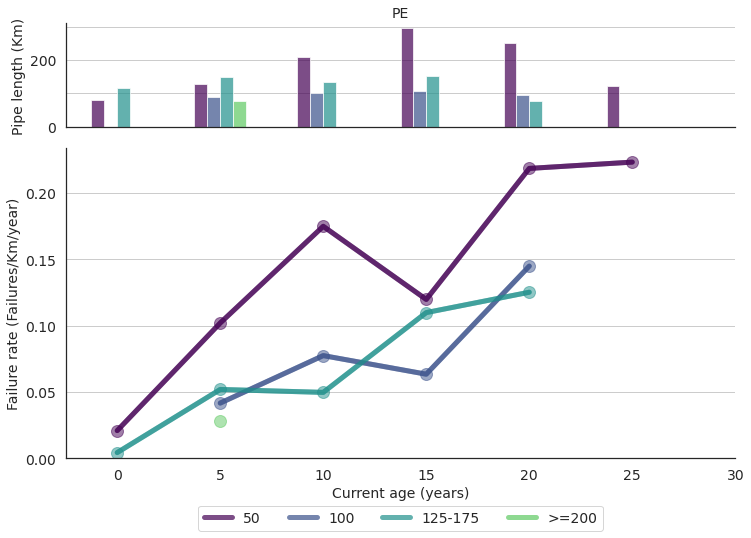

In [93]:
getAgeFailureGraphs(predoMaterials.copy())